In [1]:
from IPython.display import Image, display
import random, os
from typing import Literal
from typing_extensions import TypedDict
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

In [2]:
load_dotenv()
GOOGLE_STUDIO_KEY = os.getenv('GOOGLE_API_KEY')

In [3]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_STUDIO_KEY

In [4]:
# llm = ChatVertexAI(model="gemini-2.0-flash", temperature=0)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-002", temperature=0)

Original tutorial repository: https://github.com/langchain-ai/langchain-academy/tree/main

# Simple Graph

### State
The first thing you do when you define a graph is define the State of the graph. The State consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. The schema of the State will be the input schema to all Nodes and Edges in the graph, and can be either a TypedDict or a Pydantic model. All Nodes will emit updates to the State which are then applied using the specified reducer function.

In [5]:
class State(TypedDict):
    graph_state: str

### Nodes
In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config"

In [6]:
def node_1(state: State):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state: State):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state: State):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

### Edges
Edges connect the nodes.\
Edges define how the logic is routed and how the graph decides to stop
There are a few key types of edges:

<li>Normal Edges: Go directly from one node to the next.</li>
<li>Conditional Edges: Call a function to determine which node(s) to go to next.</li>
<li>Entry Point: Which node to call first when user input arrives.</li>
<li>Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.</li>

A node can have MULTIPLE outgoing edges. If a node has multiple out-going edges, all of those destination nodes will be executed in parallel as a part of the next superstep.

In [7]:
# Define a conditional edge (random choice)
def decide_mood(state) -> Literal["node_2", "node_3"]:
    # user_input = state['graph_state'] 
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

### Graph
The StateGraph class is the main graph class to use. This is parameterized by a user defined State object.\
To build your graph, you first define the state, you then add nodes and edges, and then you compile it. \
Compiling is a pretty simple step. It provides a few basic checks on the structure of your graph (no orphaned nodes, etc). \
You MUST compile your graph before you can use it.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

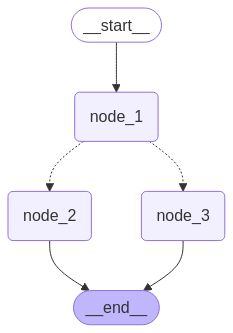

In [8]:
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation
The input is a dictionary {"graph_state": "Hi, this is lance."}, which sets the initial value for our graph state dict.

When invoke is called, the graph starts execution from the START node.
invoke() runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

The conditional edge will traverse from node 1 to node 2 or 3 using a 50/50 decision rule.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

In [11]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

### Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including HumanMessage, AIMessage, SystemMessage, and ToolMessage.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

In [9]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [10]:
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [11]:
result

AIMessage(content='The best place to see orcas in the US depends on the time of year.  There are three main regions known for orca sightings:\n\n* **Pacific Northwest (Washington, Oregon, and British Columbia, Canada):** This is generally considered the *best* place to see orcas in the US, particularly the **Salish Sea**, which includes the Puget Sound and the waters around the San Juan Islands.  The best time to see resident orcas here is from **May through September**.  These orcas primarily feed on salmon.\n\n* **Alaska:**  Alaska offers opportunities to see transient orcas, which feed on marine mammals.  **Southeast Alaska**, particularly around Juneau and Sitka, is a good spot during the **summer months**.  You might also see orcas in **Prince William Sound** and **Kenai Fjords National Park**.\n\n* **California:** While less consistent than the Pacific Northwest, orcas can be seen off the coast of California, particularly **Monterey Bay** and the **Channel Islands**, during their

### Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input **schema** or payload, rather than natural language.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the **tool's schema**.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [54]:
llm_with_tools = llm.bind_tools([multiply])

In [55]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [56]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': 'b7335a78-dfc3-4102-8600-d62b915f59f0',
  'type': 'tool_call'}]

### Messages and Reducers
`MessageState` is a state whose message key is composed of a list of `AnyMessage` along with the `add_messages` reducer

Each key in the State has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.

In [57]:
class MessagesState(MessagesState):
    pass
# This class is the shortand of 
# messages: Annotated[list[AnyMessage], add_messages]

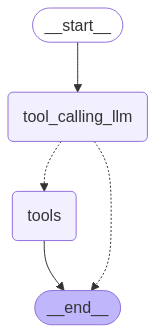

In [58]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge(START, "tool_calling_llm")
# builder.add_edge("tool_calling_llm", END)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

**ToolNode** is a node that runs the tools called in the last AIMessage.

**tools_condition** is used in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.

In [59]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello there! How can I help you today?


In [62]:
messages = [HumanMessage(content="Hello, what is 2 times 11?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Hello, what is 2 times 11?
================================== Ai Message ==================================
Tool Calls:
  multiply (a2e5d3f0-8b86-4fb9-ab54-209f798c77f8)
 Call ID: a2e5d3f0-8b86-4fb9-ab54-209f798c77f8
  Args:
    a: 2.0
    b: 11.0
================================= Tool Message =================================
Name: multiply

22


In [63]:
messages

{'messages': [HumanMessage(content='Hello, what is 2 times 11?', additional_kwargs={}, response_metadata={}, id='a2561356-0955-4bbc-bbaf-44e009c2fed9'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 11.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run-de67ffa3-8332-44c2-a9a5-9e3a14611272-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 11.0}, 'id': 'a2e5d3f0-8b86-4fb9-ab54-209f798c77f8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 25, 'output_tokens': 3, 'total_tokens': 28, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='22', name='multiply', id='ccb1481f-b156-4dbd-b1b2-cc06724403b1', tool_call_id='a2e5d3f0-8b86-4fb9-ab54-209f798c77f8')]}

## Simple Agent
Developing a simple agent following the ReAct architecture (https://arxiv.org/abs/2210.03629), consisting of:
<li>Act: the model can call specific tools</li>
<li>Observe: the tool output is passed back to the model</li>
<li>Reason: based on the tool output the model decide what to do next</li>

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-002", temperature=0)
llm_with_tools = llm.bind_tools(tools)

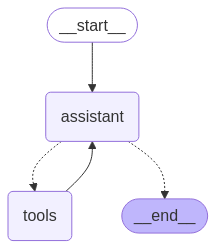

In [7]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (f20503d9-b4d6-4e61-a85d-fb6fa1984594)
 Call ID: f20503d9-b4d6-4e61-a85d-fb6fa1984594
  Args:
    a: 3.0
    b: 4.0
  multiply (96bc0c2a-74c4-44ca-afc7-9c25f670ee64)
 Call ID: 96bc0c2a-74c4-44ca-afc7-9c25f670ee64
  Args:
    a: 7.0
    b: 2.0
  divide (a721bc03-0ae7-42df-aad2-526582534893)
 Call ID: a721bc03-0ae7-42df-aad2-526582534893
  Args:
    a: 14.0
    b: 5.0
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================

The output of

### Introducing Memory
Every time we make an invocation on the constructed graph, the memory is wiped.

LangGraph can use a checkpointer to automatically save the graph state after each step. When you compile graph with a checkpointer, the checkpointer saves a checkpoint of the graph state at every super-step (sequential node are separate super-step, while parallel nodes shares the same super-step).

In [10]:
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (3884a276-8988-4333-87f7-75d7a5dede67)
 Call ID: 3884a276-8988-4333-87f7-75d7a5dede67
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


The `thread_id` is needed every time we want to use memory, it will store the collection of graph states.

In general, `threads` allow access to graph's state after execution.

A thread is a unique ID assigned to each checkpoint saved by a checkpointer. When invoking graph with a checkpointer, you must specify a `thread_id` as part of the configurable portion of the `config`.

In [11]:
messages = [HumanMessage(content="Multiply that by 2.")]

# By passing the same config, we are referring to the same thread_id, thus proceeding from the previous checkpoint
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (3884a276-8988-4333-87f7-75d7a5dede67)
 Call ID: 3884a276-8988-4333-87f7-75d7a5dede67
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (7a0421ae-a8b5-4eef-ad7c-d8dd374eaf35)
 Call ID: 7a0421ae-a8b5-4eef-ad7c-d8dd374eaf35
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

14
